In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
plt.rcParams.update({'font.size': 12})
# import sys
# sys.path.append('../input')
# print (sys.path)

In [5]:
data = pd.read_csv('C:\\Users\\Gagan Aggawal\\Desktop\\project\\coronaAnalysis\\input\\covid_19_data.csv', parse_dates = ['ObservationDate', 'Last Update'])
print (data.shape)
# print (data)
# print (str(data.ObservationDate))
print ('Last Update: ' + str(data.ObservationDate.max()))

(16409, 8)
Last Update: 2020-04-18 00:00:00


In [12]:
checkdup = data.groupby(['Country/Region','Province/State','ObservationDate']).count().iloc[:,0]
checkdup[checkdup>1]

Country/Region  Province/State  ObservationDate
Mainland China  Gansu           2020-03-11         2
                                2020-03-12         2
                Hebei           2020-03-11         2
                                2020-03-12         2
Name: SNo, dtype: int64

In [13]:
data[(data['Country/Region']=='US') & (data['Province/State'] == 'Recovered')].tail()

SNo ObservationDate Province/State Country/Region  \
15093  15094      2020-04-14      Recovered             US   
15413  15414      2020-04-15      Recovered             US   
15733  15734      2020-04-16      Recovered             US   
16053  16054      2020-04-17      Recovered             US   
16373  16374      2020-04-18      Recovered             US   

              Last Update  Confirmed  Deaths  Recovered  
15093 2020-04-14 23:41:11        0.0     0.0    47763.0  
15413 2020-04-15 23:04:26        0.0     0.0    52096.0  
15733 2020-04-16 23:38:19        0.0     0.0    54703.0  
16053 2020-04-17 23:38:48        0.0     0.0    58545.0  
16373 2020-04-18 22:40:18        0.0     0.0    64840.0

In [14]:
# Clean data
data = data[(data.Confirmed>0) | (data['Province/State'] == 'Recovered')]
data = data.drop(['SNo', 'Last Update'], axis=1)
data = data.rename(columns={'Country/Region': 'Country', 'ObservationDate':'Date'})
# To check null values
data.isnull().sum()


Date                 0
Province/State    8145
Country              0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [15]:
data = data.sort_values(['Date','Country','Province/State'])
# Add column of days since first case
data['first_date'] = data.groupby('Country')['Date'].transform('min')
data['days'] = (data['Date'] - data['first_date']).dt.days

In [16]:
data

Date Province/State             Country  Confirmed  Deaths  \
35    2020-01-22            NaN               Japan        2.0     0.0   
20    2020-01-22          Macau               Macau        1.0     0.0   
0     2020-01-22          Anhui      Mainland China        1.0     0.0   
1     2020-01-22        Beijing      Mainland China       14.0     0.0   
2     2020-01-22      Chongqing      Mainland China        6.0     0.0   
...          ...            ...                 ...        ...     ...   
16265 2020-04-18            NaN  West Bank and Gaza      418.0     2.0   
16266 2020-04-18            NaN      Western Sahara        6.0     0.0   
16267 2020-04-18            NaN               Yemen        1.0     0.0   
16268 2020-04-18            NaN              Zambia       57.0     2.0   
16269 2020-04-18            NaN            Zimbabwe       25.0     3.0   

       Recovered first_date  days  
35           0.0 2020-01-22     0  
20           0.0 2020-01-22     0  
0            0.0 2020-01-22     0  
1            0.0 2020-01-22     0  
2            0.0 2020-01-22     0  
...          ...        ...   ...  
16265       69.0 2020-03-26    23  
16266        0.0 2020-04-05    13  
16267        0.0 2020-04-10     8  
16268       33.0 2020-03-18    31  
16269        2.0 2020-03-20    29  

[16186 rows x 8 columns]

In [17]:
latest = data[data.Date == data.Date.max()]
print ('Total confirmed cases: %.d' %np.sum(latest['Confirmed']))
print ('Total death cases: %.d' %np.sum(latest['Deaths']))
print ('Total recovered cases: %.d' %np.sum(latest['Recovered']))
print ('Death rate %%: %.2f' % (np.sum(latest['Deaths'])/np.sum(latest['Confirmed'])*100))

Total confirmed cases: 2317759
Total death cases: 159510
Total recovered cases: 592319
Death rate %: 6.88


In [20]:
cty = latest.groupby('Country').sum()
cty['Death Rate'] = cty['Deaths'] / cty['Confirmed'] * 100
cty['Recovery Rate'] = cty['Recovered'] / cty['Confirmed'] * 100
cty['Active'] = cty['Confirmed'] - cty['Deaths'] - cty['Recovered']
cty.drop('days',axis=1).sort_values('Confirmed', ascending=False).head(10)

Confirmed   Deaths  Recovered  Death Rate  Recovery Rate  \
Country                                                                    
US               732197.0  38664.0    64840.0    5.280546       8.855540   
Spain            191726.0  20043.0    74797.0   10.453981      39.012445   
Italy            175925.0  23227.0    44927.0   13.202785      25.537587   
France           149149.0  19345.0    36587.0   12.970251      24.530503   
Germany          143342.0   4459.0    85400.0    3.110742      59.577793   
UK               115314.0  15498.0      414.0   13.439825       0.359020   
Mainland China    82718.0   4632.0    77029.0    5.599749      93.122416   
Turkey            82329.0   1890.0    10453.0    2.295667      12.696620   
Iran              80868.0   5031.0    55987.0    6.221249      69.232577   
Belgium           37183.0   5453.0     8348.0   14.665304      22.451120   

                  Active  
Country                   
US              628693.0  
Spain            96886.0  
Italy           107771.0  
France           93217.0  
Germany          53483.0  
UK               99402.0  
Mainland China    1057.0  
Turkey           69986.0  
Iran             19850.0  
Belgium          23382.0

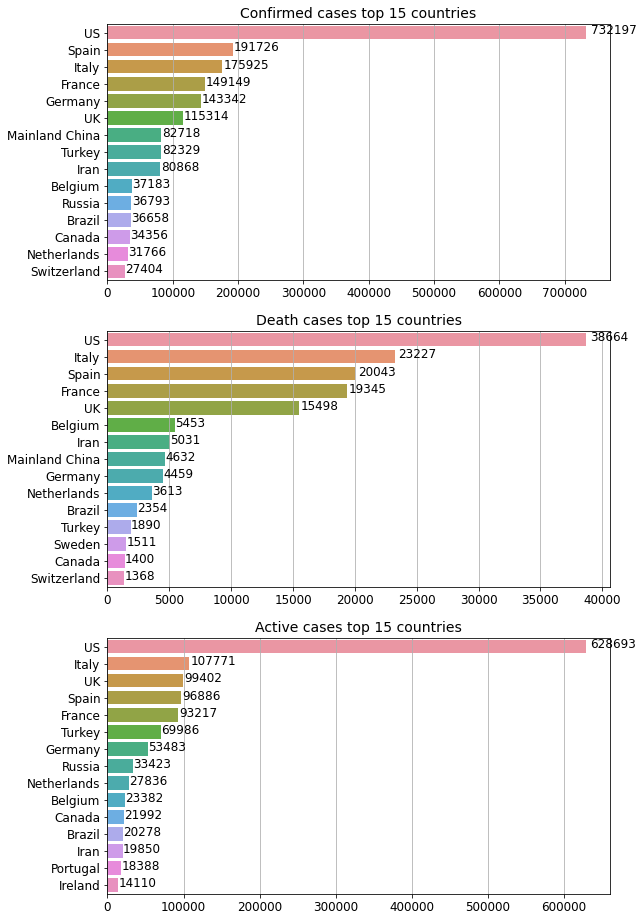

In [34]:
def plot_new(column, title):
    _ = cty.sort_values(column, ascending=False).head(15)
    g = sns.barplot(_[column], _.index)
    plt.title(title, fontsize=14)
    plt.ylabel(None)
    plt.xlabel(None)
    plt.grid(axis='x')
#     print (_[column])
#     print (_.index)
    for i, v in enumerate(_[column]):
#         print (i)
#         print (v)
        if column == 'Death Rate':
            g.text(v*1.01, i+0.1, str(round(v,2)))
        else:
#             print (v*1.01)
#             print (i+0.1)
            g.text(v*1.01, i+0.1, str(int(v)))

plt.figure(figsize=(9,16))
plt.subplot(311)
plot_new('Confirmed','Confirmed cases top 15 countries')
plt.subplot(312)
plot_new('Deaths','Death cases top 15 countries')
plt.subplot(313)
plot_new('Active','Active cases top 15 countries')

plt.show()

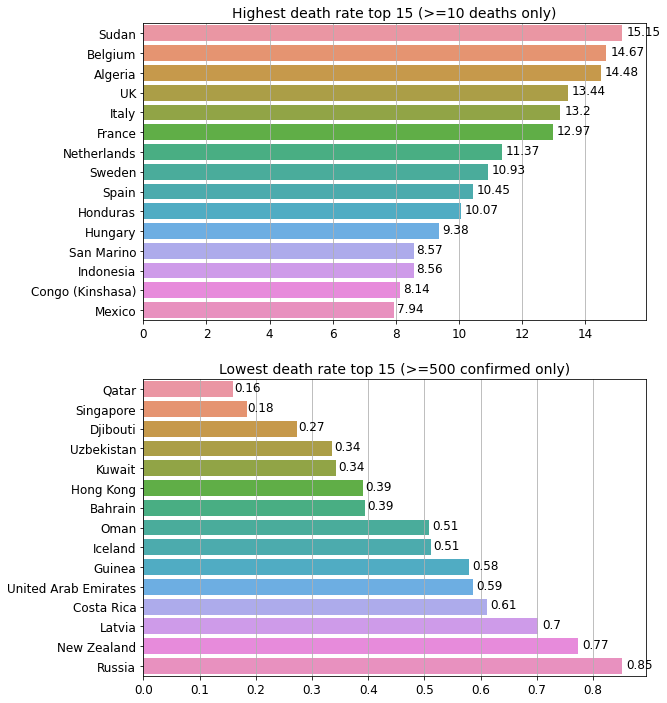

In [35]:
def plot_rate(rank, title):
    if rank == 'highest':
        _ = cty[cty.Deaths>=10].sort_values('Death Rate', ascending=False).head(15)
    else:
        _ = cty[cty.Confirmed>=500].sort_values('Death Rate').head(15)
    g = sns.barplot(_['Death Rate'], _.index)
    plt.title(title,fontsize = 14)
    plt.ylabel(None)
    plt.xlabel(None)
    plt.grid(axis='x')
    for i, v in enumerate(_['Death Rate']):
        g.text(v*1.01, i+0.1, str(round(v,2)))
        
        
plt.figure(figsize=(9,12))
plt.subplot(211)
plot_rate('highest','Highest death rate top 15 (>=10 deaths only)')
plt.subplot(212)
plot_rate('lowest','Lowest death rate top 15 (>=500 confirmed only)')

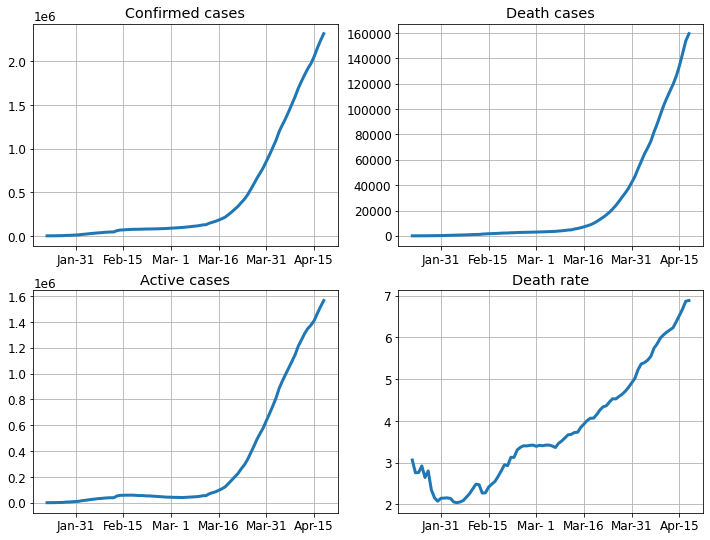

In [36]:
import matplotlib.dates as mdates
months_fmt = mdates.DateFormatter('%b-%e')

evo = data.groupby('Date')[['Confirmed','Deaths','Recovered']].sum()
evo['Active'] = evo['Confirmed'] - evo['Deaths'] - evo['Recovered']
evo['Death Rate'] = evo['Deaths'] / evo['Confirmed'] * 100
evo['Recover Rate'] = evo['Recovered'] / evo['Confirmed'] * 100
fig, ax = plt.subplots(2, 2, figsize=(12,9))

def plot_evo(num, col, title):
    ax[num].plot(evo[col], lw=3)
    ax[num].set_title(title)
    ax[num].xaxis.set_major_locator(plt.MaxNLocator(7))
    ax[num].xaxis.set_major_formatter(months_fmt)
    ax[num].grid(True)
    
plot_evo((0,0), 'Confirmed', 'Confirmed cases')
plot_evo((0,1), 'Deaths', 'Death cases')
plot_evo((1,0), 'Active', 'Active cases')
plot_evo((1,1), 'Death Rate', 'Death rate')

plt.show()

In [38]:
def plot_cty(num, evo_col, title):
    ax[num].plot(evo_col, lw=3)
    ax[num].set_title(title)
    ax[num].xaxis.set_major_locator(plt.MaxNLocator(7))
    ax[num].xaxis.set_major_formatter(months_fmt)
    ax[num].grid(True)

def evo_cty(country):
    evo_cty = data[data.Country==country].groupby('Date')[['Confirmed','Deaths','Recovered']].sum()
    evo_cty['Active'] = evo_cty['Confirmed'] - evo_cty['Deaths'] - evo_cty['Recovered']
    evo_cty['Death Rate'] = evo_cty['Deaths'] / evo_cty['Confirmed'] * 100
    plot_cty((0,0), evo_cty['Confirmed'], 'Confirmed cases')
    plot_cty((0,1), evo_cty['Deaths'], 'Death cases')
    plot_cty((1,0), evo_cty['Active'], 'Active cases')
    plot_cty((1,1), evo_cty['Death Rate'], 'Death rate')
    fig.suptitle(country, fontsize=16)
    plt.show()

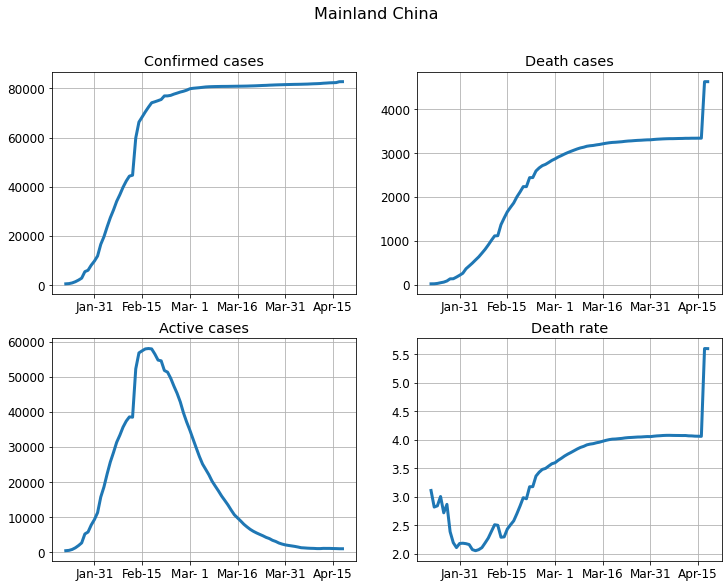

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(12,9))
evo_cty('Mainland China')

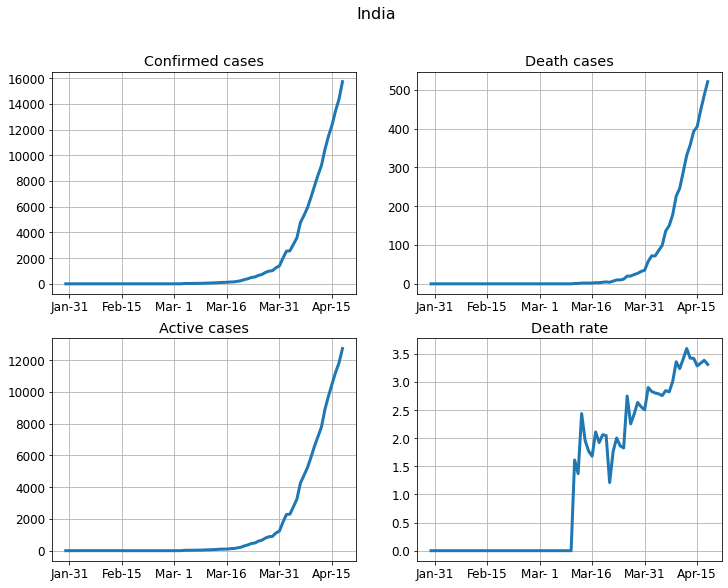

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(12,9))
evo_cty('India')

C:\Users\Gagan Aggawal\Anaconda3\envs\gagan\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


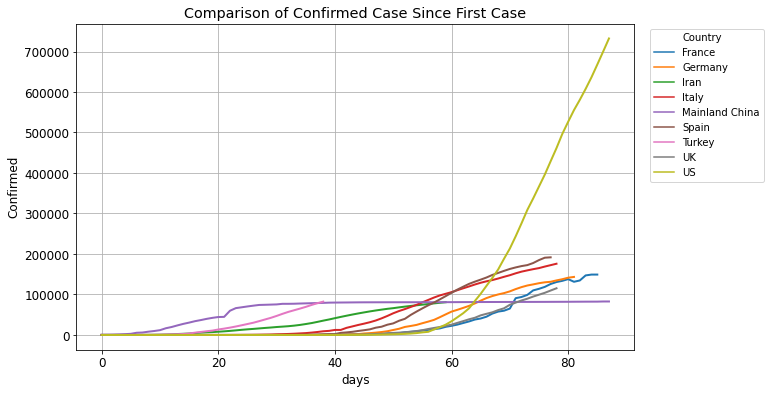

In [41]:
df_break = data.groupby(['Country','days'])['Confirmed','Deaths'].sum().reset_index()
top10case = latest.sort_values('Confirmed', ascending=False).head(10)['Country'].to_list()
top10death = latest.sort_values('Deaths', ascending=False).head(10)['Country'].to_list()

_ = df_break[df_break.Country.isin(top10case)]
plt.figure(figsize=(10,6))
sns.lineplot(x='days',y='Confirmed', data=_, hue='Country', lw=2)
plt.legend(bbox_to_anchor=(1.02, 1), fontsize=10)
plt.grid(True)
plt.title('Comparison of Confirmed Case Since First Case')
plt.show()

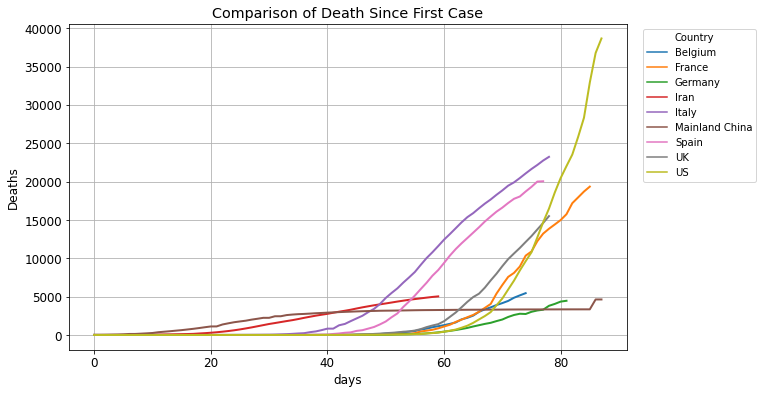

In [42]:
_ = df_break[df_break.Country.isin(top10death)]
plt.figure(figsize=(10,6))
sns.lineplot(x='days',y='Deaths', data=_, hue='Country', lw=2)
plt.legend(bbox_to_anchor=(1.02, 1), fontsize=10)
plt.grid(True)
plt.title('Comparison of Death Since First Case')
plt.show()

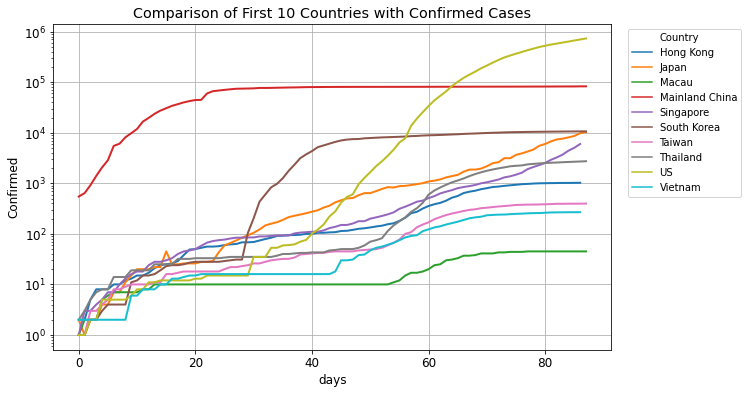

In [43]:
# Trajectory of first 10 countries with confirmed cases 
early_10 = data.groupby('Country')['Date'].min().sort_values().head(10).index
_ = df_break[df_break.Country.isin(early_10)]
plt.figure(figsize=(10,6))
sns.lineplot(x='days',y='Confirmed', data=_, hue='Country', lw=2)
plt.legend(bbox_to_anchor=(1.02, 1), fontsize=10)
plt.yscale('log')
plt.grid(True)
plt.title('Comparison of First 10 Countries with Confirmed Cases')
plt.show()